### Make OpenEO connection

In [4]:
import openeo
from datetime import datetime  


#token SENTINEL
connection = openeo.connect("https://openeo.dataspace.copernicus.eu/").authenticate_oidc()

Authenticated using refresh token.


Load in Cube without METEO


In [5]:
#Get desired data
from preprocessing import worldcereal_preprocessed_inputs

EXTENT = dict(zip(["west", "south", "east", "north"], [5.19, 51.25, 5.21, 51.26]))
EXTENT['crs'] = "EPSG:4326"

STARTDATE = '2020-11-01'
ENDDATE = '2021-10-31'

#TODO aggregator for including METEO?

input_cube = worldcereal_preprocessed_inputs(
     connection = connection,
     bbox = EXTENT,
     start = STARTDATE,
     end = ENDDATE,
     METEO_collection=None,
     S2_collection= "SENTINEL2_L2A",
     S1_collection= "SENTINEL1_GRD",
     DEM_collection= "COPERNICUS_30"
)


Save the input cube

In [6]:
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M_%S")
outputfile_name = str(formatted_datetime) + '_input_cube_worldCereal.nc'

input_cube.execute_batch(outputfile = outputfile_name,
                        description='world cereal data collection')

0:00:00 Job 'j-240517a35acc48b697839a923dd5fe56': send 'start'
0:00:18 Job 'j-240517a35acc48b697839a923dd5fe56': created (progress 0%)
0:00:23 Job 'j-240517a35acc48b697839a923dd5fe56': created (progress 0%)
0:00:30 Job 'j-240517a35acc48b697839a923dd5fe56': created (progress 0%)
0:00:38 Job 'j-240517a35acc48b697839a923dd5fe56': created (progress 0%)
0:00:48 Job 'j-240517a35acc48b697839a923dd5fe56': created (progress 0%)
0:01:02 Job 'j-240517a35acc48b697839a923dd5fe56': created (progress 0%)
0:01:18 Job 'j-240517a35acc48b697839a923dd5fe56': running (progress N/A)
0:01:38 Job 'j-240517a35acc48b697839a923dd5fe56': running (progress N/A)
0:02:04 Job 'j-240517a35acc48b697839a923dd5fe56': running (progress N/A)
0:02:35 Job 'j-240517a35acc48b697839a923dd5fe56': running (progress N/A)
0:03:13 Job 'j-240517a35acc48b697839a923dd5fe56': running (progress N/A)
0:04:00 Job 'j-240517a35acc48b697839a923dd5fe56': running (progress N/A)
0:04:59 Job 'j-240517a35acc48b697839a923dd5fe56': running (progress

<BatchJob job_id='j-240517a35acc48b697839a923dd5fe56'>

Run the presto UDF and fetch presto features

In [7]:
from datetime import datetime

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M_%S")
outputfile_name = str(formatted_datetime) + '_output_presto.nc'

udf = openeo.UDF.from_file("udf_presto.py")

prediction = input_cube.apply_neighborhood(
    process=udf,
    size=[
        {"dimension": "x", "value": 100, "unit": "px"},
        {"dimension": "y", "value": 100, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": 0, "unit": "px"},
        {"dimension": "y", "value": 0, "unit": "px"},
    ],
)

presto_list = ["presto_" + str(i) for i in range(1, 129)]
prediction = prediction.rename_labels(dimension="bands",target= presto_list)

prediction.execute_batch(outputfile = outputfile_name,
                        description='world cereal inference',
                        job_options={'driver-memory': '4g',
                                    'executor-memoryOverhead':'8g'} )

0:00:00 Job 'j-2405171879c44f5aac716b6b0ca23b92': send 'start'
0:00:17 Job 'j-2405171879c44f5aac716b6b0ca23b92': created (progress 0%)
0:00:22 Job 'j-2405171879c44f5aac716b6b0ca23b92': created (progress 0%)
0:00:29 Job 'j-2405171879c44f5aac716b6b0ca23b92': running (progress N/A)
0:00:37 Job 'j-2405171879c44f5aac716b6b0ca23b92': running (progress N/A)
0:00:47 Job 'j-2405171879c44f5aac716b6b0ca23b92': running (progress N/A)
0:01:00 Job 'j-2405171879c44f5aac716b6b0ca23b92': running (progress N/A)
0:01:16 Job 'j-2405171879c44f5aac716b6b0ca23b92': running (progress N/A)
0:01:36 Job 'j-2405171879c44f5aac716b6b0ca23b92': running (progress N/A)
0:02:11 Job 'j-2405171879c44f5aac716b6b0ca23b92': running (progress N/A)
0:02:41 Job 'j-2405171879c44f5aac716b6b0ca23b92': running (progress N/A)
0:03:19 Job 'j-2405171879c44f5aac716b6b0ca23b92': running (progress N/A)
0:04:06 Job 'j-2405171879c44f5aac716b6b0ca23b92': running (progress N/A)
0:05:05 Job 'j-2405171879c44f5aac716b6b0ca23b92': running (prog

<BatchJob job_id='j-2405171879c44f5aac716b6b0ca23b92'>

Calculate the presto features and run the classifier on top

In [8]:

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M_%S")
outputfile_name = str(formatted_datetime) + '_output_worldcereal.nc'

udf = openeo.UDF.from_file("udf_worldcereal_inference.py")

prediction = input_cube.apply_neighborhood(
    process=udf,
    size=[
        {"dimension": "x", "value": 100, "unit": "px"},
        {"dimension": "y", "value": 100, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": 0, "unit": "px"},
        {"dimension": "y", "value": 0, "unit": "px"},
    ],
)

prediction = prediction.rename_labels(dimension="bands",target= ["output_catboost"])

prediction.execute_batch(outputfile = outputfile_name,
                        description='world cereal inference',
                        job_options={'driver-memory': '4g',
                                    'executor-memoryOverhead':'8g'} )


0:00:00 Job 'j-240517a75f8846a88725dcb3c5da55a5': send 'start'
0:00:16 Job 'j-240517a75f8846a88725dcb3c5da55a5': created (progress 0%)
0:00:21 Job 'j-240517a75f8846a88725dcb3c5da55a5': created (progress 0%)
0:00:28 Job 'j-240517a75f8846a88725dcb3c5da55a5': created (progress 0%)
0:00:39 Job 'j-240517a75f8846a88725dcb3c5da55a5': created (progress 0%)
0:00:49 Job 'j-240517a75f8846a88725dcb3c5da55a5': created (progress 0%)
0:01:02 Job 'j-240517a75f8846a88725dcb3c5da55a5': created (progress 0%)
0:01:18 Job 'j-240517a75f8846a88725dcb3c5da55a5': created (progress 0%)
0:01:38 Job 'j-240517a75f8846a88725dcb3c5da55a5': running (progress N/A)
0:02:03 Job 'j-240517a75f8846a88725dcb3c5da55a5': running (progress N/A)
0:02:34 Job 'j-240517a75f8846a88725dcb3c5da55a5': running (progress N/A)
0:03:12 Job 'j-240517a75f8846a88725dcb3c5da55a5': running (progress N/A)
0:03:59 Job 'j-240517a75f8846a88725dcb3c5da55a5': running (progress N/A)
0:04:58 Job 'j-240517a75f8846a88725dcb3c5da55a5': running (progress 

<BatchJob job_id='j-240517a75f8846a88725dcb3c5da55a5'>

Fetch the output and visualise

(116, 144)

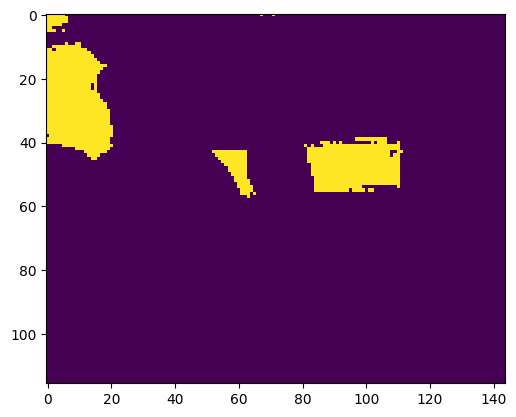

In [10]:
import xarray as xr
import matplotlib.pyplot as plt

output = xr.open_dataset('2024_05_17_14_56_51_output_worldcereal.nc')
output = output['output_catboost'].to_numpy().squeeze()
plt.imshow(output)

output.shape


In [15]:
presto_ft = xr.open_dataset('2024_05_17_14_00_16_output_presto.nc')

print(presto_ft['presto_1'])


<xarray.DataArray 'presto_1' (t: 1, y: 116, x: 144)> Size: 134kB
[16704 values with dtype=float64]
Coordinates:
  * t        (t) datetime64[ns] 8B 1970-01-01
  * x        (x) float64 1kB 6.528e+05 6.528e+05 ... 6.542e+05 6.542e+05
  * y        (y) float64 928B 5.681e+06 5.681e+06 ... 5.68e+06 5.68e+06
Attributes:
    long_name:     presto_1
    units:         
    grid_mapping:  crs


### Check reference

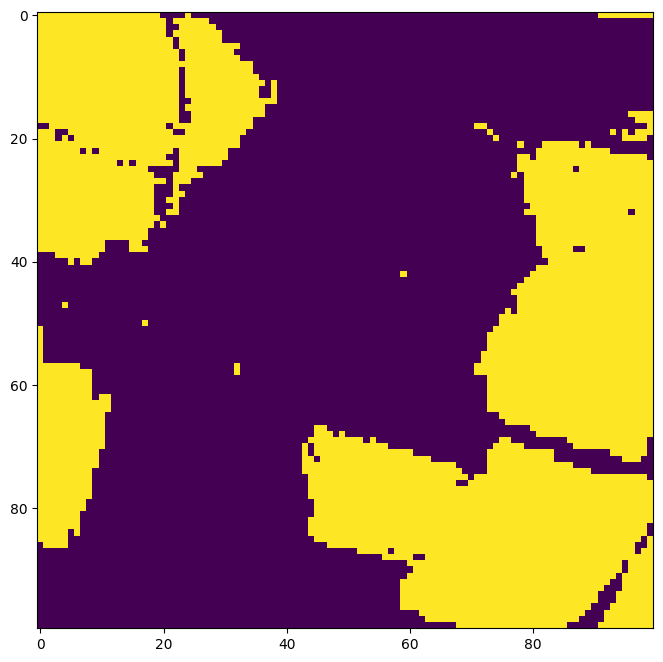